In [1]:
import numpy as np
import pandas as pd

## Read Data ##

In [2]:
df_train = pd.read_csv('../input/train.csv', encoding='utf-8')
df_train['id'] = df_train['id'].apply(str)

In [3]:
df_test = pd.read_csv('../input/test.csv', encoding='utf-8')
df_test['test_id'] = df_test['test_id'].apply(str)

In [4]:
df_all = pd.concat((df_train, df_test))
df_all['question1'].fillna('', inplace=True)
df_all['question2'].fillna('', inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


## Create Vocab ##

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
import itertools

In [6]:
counts_vectorizer = CountVectorizer(max_features=10000-1).fit(
    itertools.chain(df_all['question1'], df_all['question2']))
other_index = len(counts_vectorizer.vocabulary_)

In [7]:
print(counts_vectorizer.vocabulary_)

{'what': 9789, 'is': 4792, 'the': 8985, 'step': 8560, 'by': 1483, 'guide': 4019, 'to': 9097, 'invest': 4740, 'in': 4519, 'share': 8095, 'market': 5543, 'india': 4548, 'story': 8588, 'of': 6267, 'diamond': 2663, 'how': 4339, 'can': 1535, 'increase': 4539, 'speed': 8433, 'my': 5987, 'internet': 4699, 'connection': 2097, 'while': 9804, 'using': 9464, 'vpn': 9667, 'why': 9817, 'am': 575, 'mentally': 5681, 'very': 9568, 'lonely': 5365, 'solve': 8362, 'it': 4818, 'which': 9803, 'one': 6310, 'dissolve': 2767, 'water': 9729, 'sugar': 8682, 'salt': 7832, 'and': 621, 'carbon': 1575, 'di': 2653, 'oxide': 6450, 'astrology': 851, 'capricorn': 1565, 'sun': 8702, 'cap': 1553, 'moon': 5884, 'rising': 7675, 'does': 2816, 'that': 8983, 'say': 7873, 'about': 280, 'me': 5617, 'should': 8151, 'buy': 1479, 'be': 1076, 'good': 3926, 'when': 9797, 'do': 2804, 'you': 9966, 'use': 9456, 'instead': 4647, 'motorola': 5915, 'company': 2001, 'hack': 4047, 'method': 5717, 'find': 3536, 'separation': 8037, 'read': 73

In [8]:
print(other_index)

9999


##Prep Data##

In [9]:
import re
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [10]:
words_tokenizer = re.compile(counts_vectorizer.token_pattern)


In [11]:
words_tokenizer.findall("apple")

['apple']

In [12]:
def create_padded_seqs(texts, max_len=10):
    seqs = texts.apply(lambda s: 
        [counts_vectorizer.vocabulary_[w] if w in counts_vectorizer.vocabulary_ else other_index
         for w in words_tokenizer.findall(s.lower())])
    return pad_sequences(seqs, maxlen=max_len)

In [13]:

print(create_padded_seqs)

<function create_padded_seqs at 0x7f665ff07950>


In [14]:
X1_train, X1_val, X2_train, X2_val, y_train, y_val = \
    train_test_split(create_padded_seqs(df_all[df_all['id'].notnull()]['question1']), 
                     create_padded_seqs(df_all[df_all['id'].notnull()]['question2']),
                     df_all[df_all['id'].notnull()]['is_duplicate'].values,
                     stratify=df_all[df_all['id'].notnull()]['is_duplicate'].values,
                     test_size=0.3, random_state=1)
X1_train

array([[   0, 9789, 2816, ..., 4519, 5441, 7024],
       [   0,    0, 9803, ..., 8888, 6358, 1904],
       [5886, 6267, 8985, ..., 6267, 9999, 1345],
       ...,
       [   0, 9789, 4792, ..., 4128,  280, 1776],
       [4339, 2673, 9999, ..., 9999, 3643, 9999],
       [   0,    0,    0, ..., 1483, 6145,  944]], dtype=int32)


##Training##

In [15]:
import keras.layers as lyr
from keras.models import Model

In [16]:
input1_tensor = lyr.Input(X1_train.shape[1:])
input2_tensor = lyr.Input(X2_train.shape[1:])

words_embedding_layer = lyr.Embedding(X1_train.max() + 1, 100)
seq_embedding_layer = lyr.LSTM(256, activation='tanh')

seq_embedding = lambda tensor: seq_embedding_layer(words_embedding_layer(tensor))

merge_layer = lyr.multiply([seq_embedding(input1_tensor), seq_embedding(input2_tensor)])

dense1_layer = lyr.Dense(16, activation='sigmoid')(merge_layer)
ouput_layer = lyr.Dense(1, activation='sigmoid')(dense1_layer)

model = Model([input1_tensor, input2_tensor], ouput_layer)

model.compile(loss='binary_crossentropy', optimizer='adam')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 10, 100)      1000000     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None

In [17]:
model.fit([X1_train, X2_train], y_train, 
          validation_data=([X1_val, X2_val], y_val), 
          batch_size=128, epochs=6, verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 283003 samples, validate on 121287 samples
Epoch 1/6
 - 100s - loss: 0.5120 - val_loss: 0.4714
Epoch 2/6
 - 95s - loss: 0.4337 - val_loss: 0.4420
Epoch 3/6
 - 94s - loss: 0.3830 - val_loss: 0.4266
Epoch 4/6
 - 94s - loss: 0.3379 - val_loss: 0.4268
Epoch 5/6
 - 91s - loss: 0.2965 - val_loss: 0.4342
Epoch 6/6
 - 102s - loss: 0.2562 - val_loss: 0.4526


## Extract Features From Model##

In [18]:
features_model = Model([input1_tensor, input2_tensor], merge_layer)
features_model.compile(loss='mse', optimizer='adam')

In [19]:
F_train = features_model.predict([X1_train, X2_train], batch_size=128)
F_val = features_model.predict([X1_val, X2_val], batch_size=128)

##Train XGBoost##

In [20]:
import xgboost as xgb

In [21]:
dTrain = xgb.DMatrix(F_train, label=y_train)
dVal = xgb.DMatrix(F_val, label=y_val)

In [22]:
xgb_params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'eval_metric': 'logloss',
    'eta': 0.1, 
    'max_depth': 9,
    'subsample': 0.9,
    'colsample_bytree': 1 / F_train.shape[1]**0.5,
    'min_child_weight': 5,
    'silent': 1
}
bst = xgb.train(xgb_params, dTrain, 1000,  [(dTrain,'train'), (dVal,'val')], 
                verbose_eval=10, early_stopping_rounds=10)

[0]	train-logloss:0.64912	val-logloss:0.656899
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 10 rounds.
[10]	train-logloss:0.43593	val-logloss:0.491515
[20]	train-logloss:0.347939	val-logloss:0.440509
[30]	train-logloss:0.29789	val-logloss:0.422636
[40]	train-logloss:0.263585	val-logloss:0.416186
[50]	train-logloss:0.24072	val-logloss:0.41563
Stopping. Best iteration:
[45]	train-logloss:0.25071	val-logloss:0.415513



##Predict Test##

In [23]:
X1_test = create_padded_seqs(df_all[df_all['test_id'].notnull()]['question1'])
X2_test = create_padded_seqs(df_all[df_all['test_id'].notnull()]['question2'])

In [24]:
F_test = features_model.predict([X1_test, X2_test], batch_size=128)

In [25]:
dTest = xgb.DMatrix(F_test)

In [26]:
df_sub

NameError: name 'df_sub' is not defined

In [27]:
df_sub = pd.DataFrame({
        'test_id': df_all[df_all['test_id'].notnull()]['test_id'].values,
        'is_duplicate': bst.predict(dTest, ntree_limit=bst.best_ntree_limit)
    }).set_index('test_id')

In [28]:
df_sub.head()

,is_duplicate
test_id,
0,0.202031
1,0.237764
2,0.410055
3,0.197038
4,0.552286


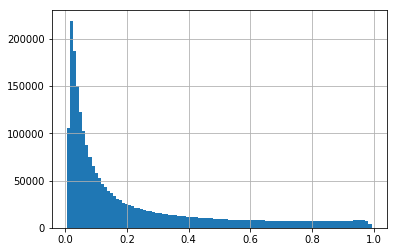

In [29]:
df_sub['is_duplicate'].hist(bins=100)